In [1]:
# El Yazısı Rakam Tanıma (MNIST Veri seti)

In [1]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import warnings 
warnings.filterwarnings('ignore')

from keras import models
from keras.models import Sequential
from keras.layers import Conv2D ,MaxPool2D ,LeakyReLU, MaxPooling2D , Dense ,Dropout , Flatten , BatchNormalization
from keras.utils import to_categorical
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adam ,RMSprop
from keras.callbacks import ReduceLROnPlateau


import pickle








Using TensorFlow backend.


# Veri setinin yüklenmesi ve Görselleştirilmesi
<hr>

## Veri seti hakkında

- MNIST veri setinin özellikleri ;
    * Veri kümesinde 60.000 el yazısı örneği bulunmaktadır.
    * Görüntülerimiz 28x28 'lik pixekden oluşmaktadır.
    * Görüntülerimizde yanlızca tek renk kanalı bulunmaktadır.(28 ,28 ,1)
    * Görüntülerimiz [0-255] gri tonlama skalası arasında oluşmaktadır (0 = siyah , 255 =beyaz)
    * Görüntülerimiz toplam on adet sınıftan oluşmaktadır(rakamlardan)(0 ,1,2 ,3 ,4 ,5 ,6 ,7 ,8 ,9)
    


### Train(Eğitim) Setinin yüklenmesi

In [2]:
np.random.seed(1)
train = pd.read_csv("mnist_train.csv") # verinin yüklenmesi
train = train.iloc[np.random.permutation(len(train))] # Veri setinin karıştırılması



In [3]:
print(train.shape)

(60000, 785)


- Egitim setimizde 60.000 resim vardır ve 1. sutunumuzdaki label değişkeni bizim bu görüntülerimizin etiketidir .
- Biz bu etiket değerini y_train olarak ayrıştıracağız.
- Veri setimiz (60000 ,784) şeklinde bize sunulmuştur biz bunu yeniden şekillendirme ile (60000 ,28 ,28 ,1) boyutuna getireceğiz

<br> 

###  Test Setinin Yüklenmesi

   * Test setimiz 10000 adet görsel içermektedir ,train setimizde olduğu gimi ilk sutunumuz veri setimizdeki resimlerin etiketidir.
   * Train seti için yaptığımız içlemleri bunun üzrindede uygulayacağız
    

In [4]:
test = pd.read_csv("mnist_test.csv")
x_test = np.asarray( test.iloc[: ,1:] ).reshape([-1 ,28 ,28 ,1])
y_test = np.asarray( test.iloc[: ,0]).reshape(test.shape[0] ,1)


<br>
<br>

## Eğitim ve Validasyon Verilerinin Hazırlanması
- Birkaç adım gerektir ;
    * Validasyon seti eğitim setimizin %10'undan oluşacak .
    * Her iki seti de yeniden şekillendireceğiz . (28 ,28 ,1)
    * Her iki set için etiketleri bölümleyeceğiz("Label")
    * Ben ayırma işleminde df.iloc[] ,np.asarray() gibi metodlar kullanacağım siz bunlarla ugraşmak istemez iseniz sklearn.model_selection içerisindeki train_test_split metodunu kullanabilirsiniz
    

In [5]:
total_size = train.shape[0] # veri setimizin toplam boyutunun 0. indexi  = 60000
validation_size = int(train.shape[0]*0.1) # valide edeceğimiz boyut

# asarray fonksiyonunu reshape hatası vermesin diye kullanıyoruz 
# (28 ,28 ,1 ) ile resimlendirmeye ve öğrenmeye(keras modellemesine) hazır hale getiriyoruz

# train_X ve train_y
x_train = np.asarray( train.iloc[ validation_size : , 1: ]).reshape(
    [total_size - validation_size , 28 ,28 ,1])

y_train = np.asarray( train.iloc[ validation_size : , 0 ]).reshape(
    [total_size - validation_size , 1])

# val_x ve val_y

x_val = np.asarray( train.iloc[ :validation_size  , 1:  ]).reshape(
    [validation_size , 28 ,28 ,1])

y_val = np.asarray( train.iloc[ :validation_size , 0]).reshape(
    [validation_size , 1])

In [6]:

print("Data_sets Shape ;")
print(f" X_train :{ x_train.shape }\n Y_train : { y_train.shape }\n X_val : { x_val.shape }\n Y_val : { y_val.shape }\n X_test : {x_test.shape}\n y_test : {y_test.shape}")


Data_sets Shape ;
 X_train :(54000, 28, 28, 1)
 Y_train : (54000, 1)
 X_val : (6000, 28, 28, 1)
 Y_val : (6000, 1)
 X_test : (10000, 28, 28, 1)
 y_test : (10000, 1)


# Pixel Verilerinin Normalleştirilmesi (Normalize)
- Her piksel değerimiz [0 - 250] arasındadır. Bu değer aralığı oğrenmemizi yavaşlatıp ,zorlaştıracapı için Normalleştirmenin yapılması gereklidir. 
- Her pikseli 255 ile normalleştirdiğimiz için değerlerimiz [0 - 1 ] arasınıa ölçeklenecektir.

In [7]:
x_train = x_train / 255
x_val = x_val / 255
x_test = x_test / 255


# Rakamların ve Veri Kümesinin görselleştirilmesi

- İlk olarak veri Kümemizdeki sınıfların sayısına bakmalıyız.
- Sonradan modellememizi etkileyeceğinden dolayı valdasyon ve test setimizdeki sınıf sayıları kendi içlerinde  ve train setine göre birbirlerine yakın şekilde dağılmalıdır aksi halde verimizde çarpıklıklara neden olabilir . Ancak bu herzaman böyle olacak diye bir şart yoktur.


<br>

### Train (egitim) setindeki Label değişkeninin sınıf sayıları :

In [8]:
pd.DataFrame(train ,columns = ["label"])

,label
15281,3
21435,2
44536,7
13518,8
47529,2
...,...
50057,0
32511,5
5192,0
12172,9


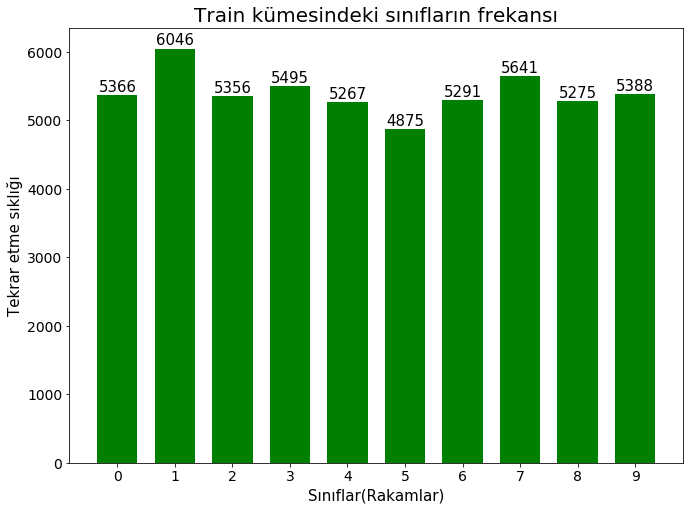

In [9]:
counts = pd.DataFrame(y_train ,columns = ["label"]).groupby("label")["label"].count()

figure = plt.figure(figsize = (11 ,8))
figure.add_subplot(111)

plt.bar(x = counts.index,
        height = counts.values,
        width =0.7,
        color = "green" )

for i in counts.index:
    plt.text(x =  i ,
             y = counts.values[i] +50, # barların üztündeki sayılar barlara doğru girmesin diye yaptık
             s = str(counts.values[i]), #bar üzerindeki sayı
             horizontalalignment = "center",# bar üzerindeki sayının hizalanması
             fontsize = 15
            )
plt.tick_params(labelsize = 14) # x ve y eksenindeki sayıların boyutunu(görsel) arttırır
plt.xticks(counts.index) # bunu koymaz isek x eksenindeki sayılar 2 şer ikişer artar 
plt.xlabel("Sınıflar(Rakamlar)",fontsize=15)
plt.ylabel("Tekrar etme sıklığı",fontsize=15)
plt.title("Train kümesindeki sınıfların frekansı",fontsize=20)
plt.savefig('digit_frequency_train.png')  
plt.show()

In [10]:
pd.DataFrame(y_train)[0].value_counts()

1    6046
7    5641
3    5495
9    5388
0    5366
2    5356
6    5291
8    5275
4    5267
5    4875
Name: 0, dtype: int64

<br>
<br>

## Validasyon setindeki Label değişkeninin sınıf sayıları :

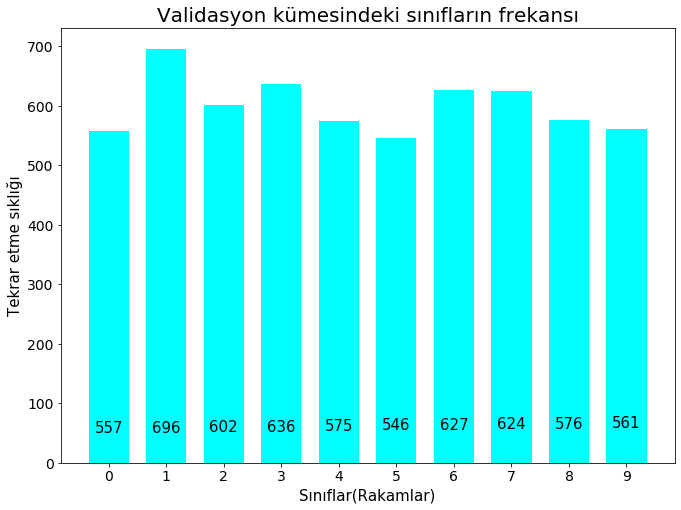

In [11]:
counts = pd.DataFrame(y_val , columns = ["label"]).groupby("label")["label"].count()

figure = plt.figure(figsize = (11 ,8))
figure.add_subplot(111)

plt.bar(x = counts.index,
        height = counts.values,
        width =0.7,
        color = "aqua" )

for i in counts.index:
    plt.text(
        x = i,
        y = counts.index[i] + 50,
        s = str(counts.values[i]),
        horizontalalignment = "center",
        fontsize = 15 )
    
plt.tick_params(labelsize = 14)
plt.xticks(counts.index)
plt.xlabel("Sınıflar(Rakamlar)",fontsize=15)
plt.ylabel("Tekrar etme sıklığı",fontsize=15)
plt.title("Validasyon kümesindeki sınıfların frekansı",fontsize=20)
plt.savefig('digit_frequency_val.png')  
plt.show()

In [12]:

pd.DataFrame(y_train)[0].value_counts()

1    6046
7    5641
3    5495
9    5388
0    5366
2    5356
6    5291
8    5275
4    5267
5    4875
Name: 0, dtype: int64

<br>
<br>

### Test setindeki Label değişkeninin sınıf sayıları :

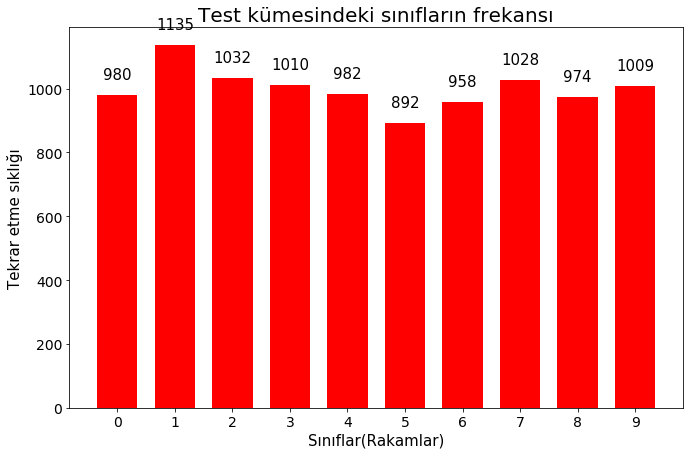

In [13]:
counts = pd.DataFrame(test , columns = ["label"]).groupby("label")["label"].count()

figure = plt.figure(figsize=(11 ,7))
figure.add_subplot(111)

plt.bar(x = counts.index,
        height = counts.values,
        width =0.7,
        color = "red" )

for i in counts.index:
    plt.text(
        x = i,
        y = counts.values[i] + 50,
        s = str(counts.values[i]),
        horizontalalignment = "center",
        fontsize = 15)
    
plt.tick_params(labelsize = 14)
plt.xticks(counts.index)
plt.xlabel("Sınıflar(Rakamlar)",fontsize=15)
plt.ylabel("Tekrar etme sıklığı",fontsize=15)
plt.title("Test kümesindeki sınıfların frekansı",fontsize=20)
plt.savefig('digit_frequency_val.png')  
plt.show()

- Veri setinmizdeki sınıf sayılarında herhangi bir anormal durum yok gönül rahatlığı ile devam edebiliriz


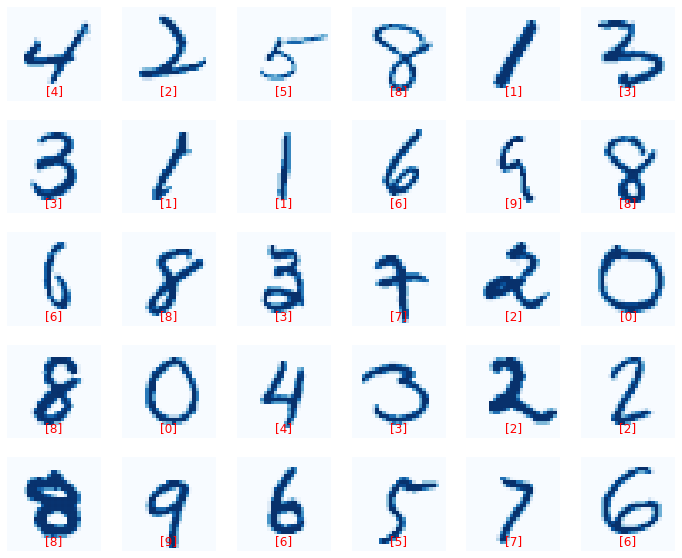

In [16]:
# Etiketleri(rakamları) görselleştirme
rows = 5
cols = 6
figure = plt.figure(figsize=(2*cols,2*rows)) #oluşucak toplam şekilerrin boyutu 

for i in range(rows*cols):
    figure.add_subplot(rows ,cols ,i+1) # her dönüşte şekle yeni grafik ekler
    plt.imshow(x_train[i].reshape([28 ,28]), cmap="Blues")
    plt.axis("off")
    plt.title(str(y_train[i]), y = 0.0,color = "red")
    
plt.savefig("digits.png")

<br> 
<br> 

# Model Kurma (Keras)
   - Seqential Model
   - Function API
    
### Model'in açıklanması:
   - 2 Convolutional Bloks
        * modelimizindeki  Her Blok'ta LeakyReIU aktivasyon katmanlarına sahip Conv2D katmanı  ,MaxPoolin katmanı ve en son Dropout katmanından oluşmaktadır
        
   - Ardından Flaatten ve Output katmanımız vardır 
   - MaxPooling2D katmanını görüntünün boyutunu küçültmek için kullanıyoruz.Örneğin (28 ,28)'lik boyuttaki resimimizi (2,2) boyutluk filtre uygulayarak , (14 ,14) 'luk boyuta indirgeriz bu sayede daha hızlı öğrenme uygulayabiliriz ve overfitting'i engelleriz
   - Output katmanı sigmoid fonksitonlu ve 10 nodes(düğüm)' e sahiptir

In [23]:
model = Sequential()

# Block 1
model.add(Conv2D(filters = 32 ,kernel_size = 3 , padding = "same" ,input_shape = (28,28,1)))
model.add(LeakyReLU())
model.add(Conv2D(filters = 32 ,kernel_size = 3 ,padding = "same"))
model.add(LeakyReLU())
model.add(MaxPool2D(pool_size = (2,2)))
model.add(Dropout(0.25))


# Block 2
model.add(Conv2D(filters = 32 ,kernel_size = 3 ,padding = "same"))
model.add(LeakyReLU())
model.add(Conv2D(filters = 64 ,kernel_size = 3 ,padding = "same"))
model.add(LeakyReLU())
model.add(MaxPool2D(pool_size = (2 ,2)))
model.add(Dropout(0.25))

model.add(Flatten())

model.add(Dense(units = 256 ,activation = "relu"))
model.add(Dense(units = 32  ,activation = "relu"))
model.add(Dense(units = 10  ,activation = "sigmoid"))



<br>
<br>

### Derleme Modeli


In [24]:
initial_lr = 0.001
loss = "sparse_categorical_crossentropy"
model.compile(Adam(lr=initial_lr), loss=loss ,metrics=['accuracy'])
model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_7 (Conv2D)            (None, 28, 28, 32)        320       
_________________________________________________________________
leaky_re_lu_6 (LeakyReLU)    (None, 28, 28, 32)        0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 28, 28, 32)        9248      
_________________________________________________________________
leaky_re_lu_7 (LeakyReLU)    (None, 28, 28, 32)        0         
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 14, 14, 32)        0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 14, 14, 32)       

<br>
<br>

### Training (Modelimizi eğitelim)
- Modeli eğitmek için model.fit() kullanlır. İçerisine çeşitli parametreler alır , batch_size ve epochs gibi.



In [28]:
epochs = 1 #20 epoch 
batch_size = 256 
history_1 = model.fit(x = x_train , y= y_train ,
                     validation_data = [x_val ,y_val],
                     batch_size = batch_size,
                     epochs = epochs)

Train on 54000 samples, validate on 6000 samples
Epoch 1/1
54000/54000 [==============================] - 56s 1ms/step - loss: 0.5621 - accuracy: 0.4334 - val_loss: 0.0778 - val_accuracy: 0.9777


In [30]:
import pickle
model.save("model.h5")
with open("history_1.h5" , "wb") as history :
    pickle.dump(history_1 ,history)
    

In [36]:
model = models.load_model("model.h5")
with open("history_1.h5" ,"rb") as history:
    history_1 = pickle.load(history)
    

In [37]:
<br>
<br>

SyntaxError: invalid syntax (<ipython-input-37-e8f8dce34e6f>, line 1)